The code used here is courtesy of Colin Carroll's "Hamiltonian Monte Carlo from Scratch" cited as:<br>
Carroll, Colin. 2019. “Hamiltonian Monte Carlo from Scratch.” Colin Carroll. April 11, 2019. https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/.<br>
The full Github repository exists at this citation:<br>
“GitHub - ColCarroll/Minimc: Just a Little MCMC.” n.d. Accessed April 28, 2024. https://github.com/ColCarroll/minimc/tree/master?tab=readme-ov-file.
<br><br>
Future work on this code could include optimization using the "splitting method" highlighted in this paper that I read, but wasn't able to figure out implementation:<br>
Shahbaba, Babak, Shiwei Lan, Wesley O. Johnson, and Radford M. Neal. 2012. “Split Hamiltonian Monte Carlo.” arXiv. http://arxiv.org/abs/1106.5941.
<br><br>
**Note that Isabel's comments in code are preceded by "I:" for clarity.**

In [11]:
# I: importing A LOT of packages...
import numpy as np
import scipy.stats as st
from tqdm import tqdm
import matplotlib.pyplot as plt
from autograd import grad

In [12]:
### I: First, must define Leapfrog integrator for use in the main HMC function. ###
# I: This integrator aims to simulate the differential equations established to
   # explore the target distribution. It does so by discretizing t, and
   # alternatingly updating p (momentum vector) and q (position vector). To
   # simulate Hamiltonian dynamics, it updates the momentum a half-step, then
   # the position a whole step, then p the other half-step. Since this process
   # occurs in a loop, most of the half-step updates combine with minimal
   # book-keeping.
def leapfrog(q, p, dVdq, potential, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : np.floatX
        Gradient of the potential at the initial coordinates
    potential : callable
        Value and gradient of the potential
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq / 2  # half step
    for _ in np.arange(np.round(path_len / step_size) - 1):
        q += step_size * p  # whole step
        V, dVdq = potential(q)
        p -= step_size * dVdq  # whole step
    q += step_size * p  # whole step
    V, dVdq = potential(q)
    p -= step_size * dVdq / 2  # half step

    # I: make sure to return the momentum at the end of the trajectory, because
       # we are sampling from pi(q, p) not pi(q).
    # momentum flip at end
    return q, -p, V, dVdq

### I: Main functionality for HMC. ###
# I: We chose the kinetic energy to be a Gaussian distribution such that
   # K(p, q) = 1/2 * p^T * M^-1 * p + log|M| + const and chose M = I so that
   # K(p, q) = 1/2 * p^T * p + const, dK/dp = p, and dK/dq = 0.
   # This allows Hamilton's equations to simplify to dq/dt = p and
   # dp/dt = -dV/dq. We can use these parameterizations to simulate q(t) and
   # p(t) for some amount of time T, resulting in a new sample q(T).
def hamiltonian_monte_carlo(
    n_samples,
    potential,
    initial_position,
    initial_potential=None,
    initial_potential_grad=None,
    tune=500,
    path_len=1,
    initial_step_size=0.1,
    integrator=leapfrog,
    max_energy_change=1000.0,
):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    tune: int
        Number of iterations to run tuning
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    initial_step_size : float
        How long each integration step is. This will be tuned automatically.
    max_energy_change : float
        The largest tolerable integration error. Transitions with energy changes
        larger than this will be declared divergences.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """
    initial_position = np.array(initial_position)
    if initial_potential is None or initial_potential_grad is None:
        initial_potential, initial_potential_grad = potential(initial_position)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    step_size = initial_step_size
    step_size_tuning = DualAveragingStepSize(step_size)
    # If initial_position is a 10d vector and n_samples is 100, we want 100 x 10 momentum draws
    # we can do this in one call to np.random.normal, and iterate over rows
    size = (n_samples + tune,) + initial_position.shape[:1]
    for idx, p0 in tqdm(enumerate(momentum.rvs(size=size)), total=size[0]):
        # Integrate over our path to get a new position and momentum
        q_new, p_new, final_V, final_dVdq = integrator(
            samples[-1],
            p0,
            initial_potential_grad,
            potential,
            path_len=2
            * np.random.rand()
            * path_len,  # We jitter the path length a bit
            step_size=step_size,
        )

        start_log_p = np.sum(momentum.logpdf(p0)) - initial_potential
        new_log_p = np.sum(momentum.logpdf(p_new)) - final_V
        energy_change = new_log_p - start_log_p

        # Check Metropolis acceptance criterion
        # I: This is important to correct for errors introduced by the leapfrog
           # integrator.
        p_accept = min(1, np.exp(energy_change))
        if np.random.rand() < p_accept:
            samples.append(q_new)
            initial_potential = final_V
            initial_potential_grad = final_dVdq
        else:
            samples.append(np.copy(samples[-1]))

        if idx < tune - 1:
            step_size, _ = step_size_tuning.update(p_accept)
        elif idx == tune - 1:
            _, step_size = step_size_tuning.update(p_accept)

    return np.array(samples[1 + tune :])

### I: Allows for optimizing the step size. ###
class DualAveragingStepSize:
    def __init__(
        self,
        initial_step_size,
        target_accept=0.8,
        gamma=0.05,
        t0=10.0,
        kappa=0.75,
    ):
        """Tune the step size to achieve a desired target acceptance.

        Uses stochastic approximation of Robbins and Monro (1951), described in
        Hoffman and Gelman (2013), section 3.2.1, and using those default values.

        Parameters
        ----------
        initial_step_size: float > 0
            Used to set a reasonable value for the stochastic step to drift towards
        target_accept: float in (0, 1)
            Will try to find a step size that accepts this percent of proposals
        gamma: float
            How quickly the stochastic step size reverts to a value mu
        t0: float > 0
            Larger values stabilize step size exploration early, while perhaps slowing
            convergence
        kappa: float in (0.5, 1]
            The smaller kappa is, the faster we forget earlier step size iterates
        """
        self.mu = np.log(10 * initial_step_size)
        self.target_accept = target_accept
        self.gamma = gamma
        self.t = t0
        self.kappa = kappa
        self.error_sum = 0
        self.log_averaged_step = 0

    def update(self, p_accept):
        """Propose a new step size.

        This method returns both a stochastic step size and a dual-averaged
        step size. While tuning, the HMC algorithm should use the stochastic
        step size and call `update` every loop. After tuning, HMC should use
        the dual-averaged step size for sampling.

        Parameters
        ----------
        p_accept: float
            The probability of the previous HMC proposal being accepted

        Returns
        -------
        float, float
            A stochastic step size, and a dual-averaged step size
        """
        self.error_sum += self.target_accept - p_accept
        log_step = self.mu - self.error_sum / (np.sqrt(self.t) * self.gamma)
        eta = self.t ** -self.kappa
        self.log_averaged_step = (
            eta * log_step + (1 - eta) * self.log_averaged_step
        )
        self.t += 1
        return np.exp(log_step), np.exp(self.log_averaged_step)


In [13]:
### I: Defining some distributions for testing. ###
def neg_log_normal(mu, sigma):
    """
    logp(x | mu, sigma) = 0.5 * log(2π) + log(σ) + 0.5 * ((x - μ)/σ)^2
    """
    def logp(x):
        return 0.5 * (np.log(2 * np.pi * sigma * sigma) + ((x - mu) / sigma) ** 2)
    return logp

# I: Negative log normal distribution
def neg_log_mvnormal(mu, sigma):
    """Use a Cholesky decomposition for more careful work."""
    def logp(x):
        k = mu.shape[0]
        return (
            k * np.log(2 * np.pi)
            + np.log(np.linalg.det(sigma))
            + np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), x - mu)
        ) * 0.5
    return logp

# I: Neal's funnel distribution
def neg_log_funnel():
    """Neal's funnel.
    The pdf is
    p(x) = N(x[0] | 0, 1) N(x[1:] | 0, exp(2 * x[0]) I )
    May cause divergences!
    """
    scale = neg_log_normal(0, 1)
    def neg_log_p(x):
        funnel_dim = x.shape[0] - 1
        if funnel_dim == 1:
            funnel = neg_log_normal(0, np.exp(2 * x[0]))
        else:
            funnel = neg_log_mvnormal(
                np.zeros(funnel_dim), np.exp(2 * x[0]) * np.eye(funnel_dim)
            )
        return scale(x[0]) + funnel(x[1:])
    return neg_log_p

# I: Mixture of prob distributions
def mixture(neg_log_probs, probs):
    """Log probability of a mixture of probabilities.

    neg_log_probs should be an iterator of negative log probabilities
    probs should be an iterator of floats of the same length that sums to 1-ish
    """
    probs = np.array(probs) / np.sum(probs)
    assert len(neg_log_probs) == probs.shape[0]
    def logp(x):
        return -logsumexp(np.log(probs) - np.array([logp(x) for logp in neg_log_probs]))
    return logp

### I: Makes using autograd functionality more compact. ###
class AutogradPotential:
    def __init__(self, potential_func):I: 
        self.potential = potential_func
        self.grad_potential = grad(potential_func)

    def __call__(self, coords):
        return self.potential(coords), self.grad_potential(coords)

In [14]:
# I: Establish a convenient figure size
FIGSIZE = (10, 7)

100%|██████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 471.57it/s]


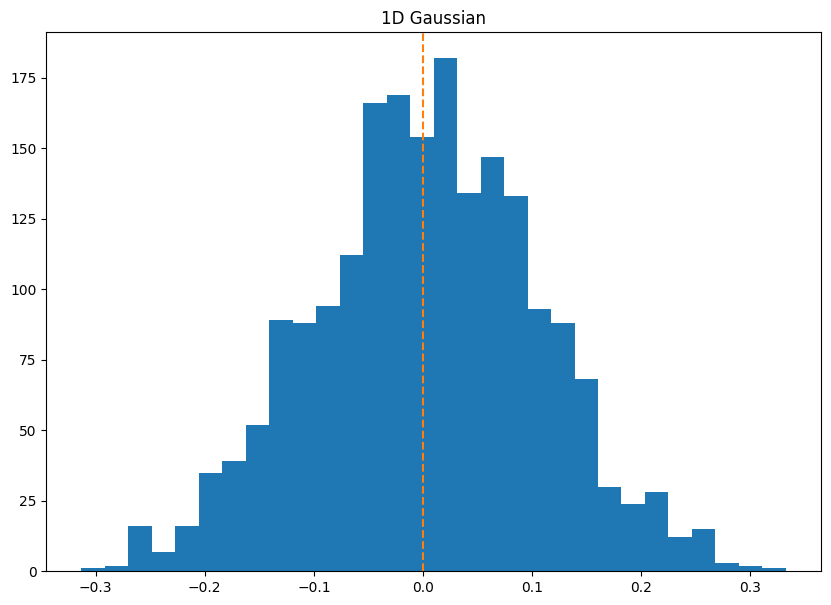

In [19]:
### I: A basic example using 2000 samples and a 1D Gaussian. ###
samples = hamiltonian_monte_carlo(2000, AutogradPotential(neg_log_normal(0, 0.1)), initial_position=0.0)

# Plotting
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.hist(samples, bins="auto")
ax.axvline(0, color="C1", linestyle="--")
ax.set_title("1D Gaussian")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 506.66it/s]


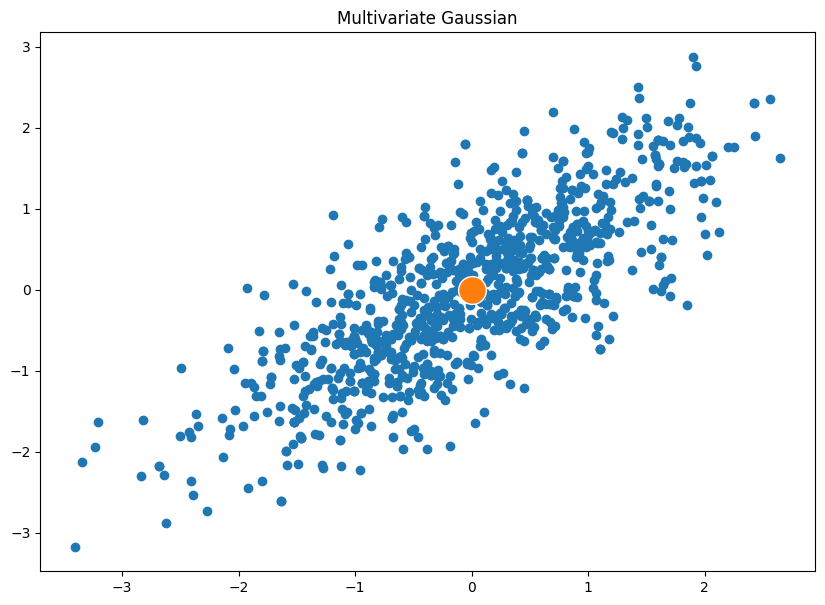

In [20]:
### I: An example using 1000 samples and a custom multivariate Gaussian distribution. ###
mu = np.zeros(2)
cov = np.array([[1.0, 0.8], [0.8, 1.0]])
neg_log_p = AutogradPotential(neg_log_mvnormal(mu, cov))

samples = hamiltonian_monte_carlo(1000, neg_log_p, np.zeros(2))

### Plot 3 ###
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(samples[:, 0], samples[:, 1], "o")
ax.plot(mu[0], mu[1], "o", color="w", ms=20, mfc="C1")
ax.set_title("Multivariate Gaussian")
plt.show()